In [7]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from plotly import graph_objs as go
from statsmodels.graphics.tsaplots import quarter_plot,month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import date
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import pickle
import warnings
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_csv(r"C:\Users\tejas\OneDrive\Desktop\project\AAPL.csv")
data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0  2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1  2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2  2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3  2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4  2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

## <font color='purple'><b>Data Preprocessing :

### <font color='magenta'><b>Transform Date to datetime object and Set as Index :

In [10]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [11]:
data.Date = pd.to_datetime(data.Date)
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [12]:
data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

In [13]:
df = data.copy()
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

In [14]:
df.set_index('Date',inplace=True)

In [15]:
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=2011, freq=None)

In [16]:
df.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

### <font color='magenta'><b>Check for Holidays :

In [17]:
data.head(1).index, data.tail(1).index

(RangeIndex(start=0, stop=1, step=1),
 RangeIndex(start=2010, stop=2011, step=1))

In [18]:
d0 = date(2012,1,3)
d1 = date(2019,12,30)
days = len(pd.date_range((d0),(d1)))
print(f'The number of days from {d0} to {d1} is {days} days')
print()
bdays = len(pd.bdate_range((d0),(d1)))
print(f'The number of business days from {d0} to {d1} is {bdays} days')
print()
print(f'The number of days from {d0} to {d1} in the given time series is {len(data)} days')

The number of days from 2012-01-03 to 2019-12-30 is 2919 days

The number of business days from 2012-01-03 to 2019-12-30 is 2085 days

The number of days from 2012-01-03 to 2019-12-30 in the given time series is 2011 days


<font color='hotpink'><b><I>So the time series contains holidays other than weekends.

### <font color='magenta'><b>Create CustomBusinessDay :

In [19]:
us_cal = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [20]:
my_range = pd.date_range(start='2012-01-03',end='2019-12-30',freq=us_cal)
print(my_range.difference(df.index))

DatetimeIndex(['2012-04-06', '2012-10-29', '2012-10-30', '2013-03-29',
               '2014-04-18', '2015-04-03', '2016-03-25', '2017-04-14',
               '2018-03-30', '2018-12-05', '2019-04-19'],
              dtype='datetime64[ns]', freq=None)


In [21]:
Cu = CustomBusinessDay(calendar=USFederalHolidayCalendar(),holidays=['2012-04-06', '2012-10-29', '2012-10-30', 
                                                                    '2013-03-29','2014-04-18', '2015-04-03', 
                                                                    '2016-03-25', '2017-04-14', '2018-03-30', 
                                                                    '2018-12-05', '2019-04-19'])
my_range = pd.date_range(start='2012-01-03',end='2019-12-30',freq=Cu)
print(my_range.difference(df.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


<font color='hotpink'><b><I>C is the custom frequency here that includes the holidays other than weekends.

In [22]:
df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   58.485714   58.928570   58.428570   58.747143   50.765709   
2012-01-04   58.571430   59.240002   58.468571   59.062859   51.038536   
2012-01-05   59.278572   59.792858   58.952858   59.718571   51.605175   
2012-01-06   59.967144   60.392857   59.888573   60.342857   52.144630   
2012-01-09   60.785713   61.107143   60.192856   60.247143   52.061932   
...                ...         ...         ...         ...         ...   
2019-12-23  280.529999  284.250000  280.369995  284.000000  282.054138   
2019-12-24  284.690002  284.890015  282.920013  284.269989  282.322266   
2019-12-26  284.820007  289.980011  284.700012  289.910004  287.923645   
2019-12-27  291.119995  293.970001  288.119995  289.799988  287.814392   
2019-12-30  289.459991  292.690002  285.220001  291.519989  289.522614   

              Volume  
Date                  
2012-01-03  75555200  
2012-01-04  65005500  
2012-01-05  67817400  
2012-01-06  79573200  
2012-01-09  98506100  
...              ...  
2019-12-23  24643000  
2019-12-24  12119700  
2019-12-26  23280300  
2019-12-27  36566500  
2019-12-30  36028600  

[2011 rows x 6 columns]

In [23]:
df = df.asfreq(Cu)

In [24]:
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1995, freq='C')

<font color='hotpink'><b><I>Now the datetime index has the frequncy C.

## <font color='purple'><b>Exploratory Data Analysis :

<font color='magenta'><b>Considering only the closing price for the analysis : 

In [25]:
df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df.head()

Close
Date                 
2012-01-03  58.747143
2012-01-04  59.062859
2012-01-05  59.718571
2012-01-06  60.342857
2012-01-09  60.247143

### <font color='magenta'><b>Downsampling the data to Monthly :

<font color='hotpink'><b>  - To reduce the granularity in the data.

In [26]:
df_m = df.resample('M').mean()
df_m.head(),df_m.tail()

(                Close
 Date                 
 2012-01-31  61.225428
 2012-02-29  71.081572
 2012-03-31  82.501104
 2012-04-30  86.571857
 2012-05-31  80.667597,
                  Close
 Date                  
 2019-08-31  204.957728
 2019-09-30  217.994999
 2019-10-31  235.260000
 2019-11-30  262.537371
 2019-12-31  275.669496)

### <font color='green'><b>Line plot :

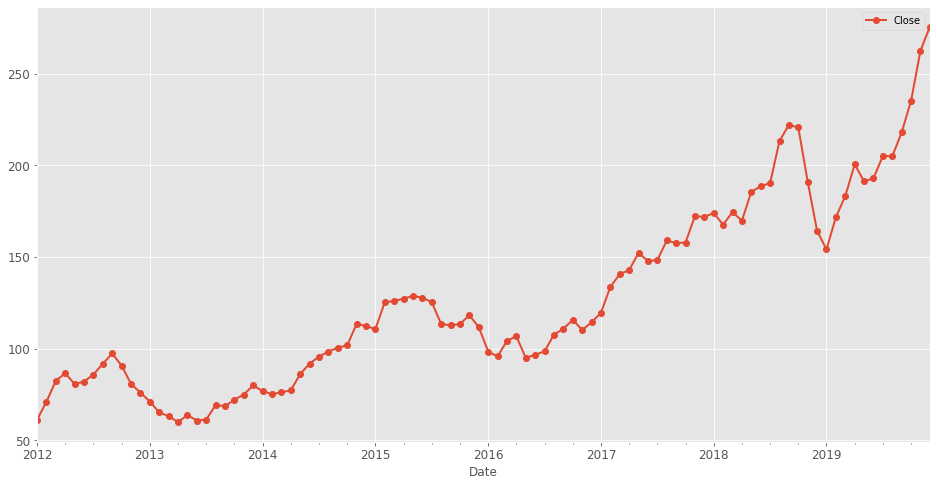

In [27]:
df_m.plot(figsize=(16,8), linewidth=2,marker='o', fontsize=12);

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_m.index,y=df_m.Close,name='stock_close'))
fig.layout.update(title_text='Line graph of Close price using Plotly with a slider',xaxis_rangeslider_visible=True)
fig.show()

<font color='green'><b>Conditions for Stationarity :
    
<font color='peach'><b> 1) Constant Mean with Time

<font color='peach'><b>2) Constant Variance with Time
     
<font color='peach'><b>3) Constant Autocorrelation with Time (i.e., the relationship between any two values at a certain amount of time must be constant)    
    
<font color='green'><b>Check for Stationarity :
    
<font color='peach'><b> 1) Visual Inspection
    
<font color='peach'><b> 2) Global vs Local check
    
<font color='peach'><b> 3) Statistical Tests :
    
<font color='orange'><b>     - ADF(Augmented Dickey-Fuller Test   
    
<font color='orange'><b>     - KPPS(Kwiatkowski–Phillips–Schmidt–Shin) Test
    
### <font color='green'><b>Visual Inspection :
    
<font color='peach'><b>   From the above line plot, the mean is not constant and the variance is also not constant. So the series is not stationary.

###  <font color='hotpink'><b>Anomaly Detection :

#### <font color='purple'><b>Seasonal-Trend Decomposition using LOESS (STL) :

In [29]:
stl = STL(df_m)
result = stl.fit()

In [30]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

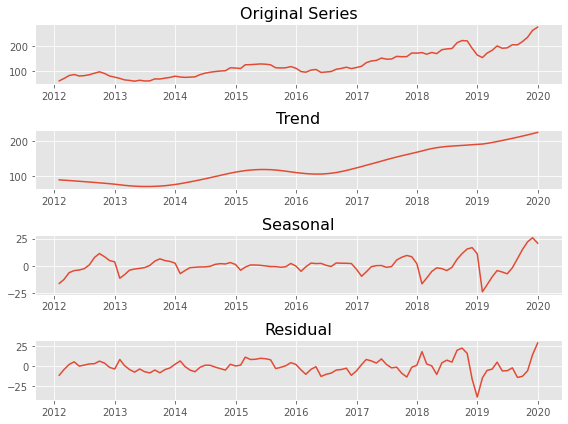

In [31]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(df_m)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

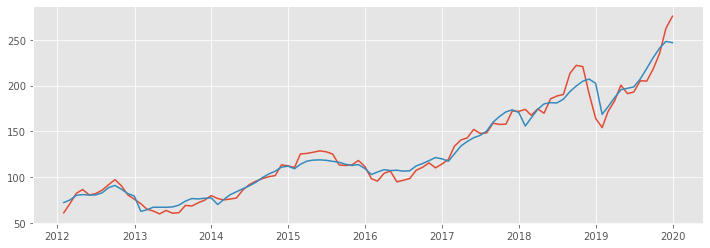

In [32]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_m)
plt.plot(estimated);

In [33]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

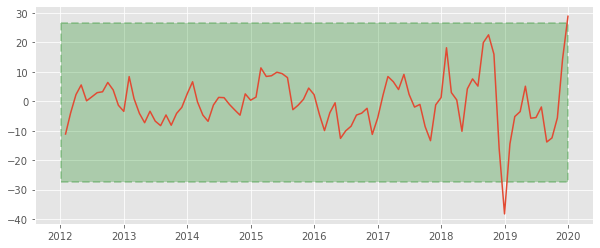

In [34]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2012,1,3), datetime(2019,12,30)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2);

<font color='maroon'><b>There is anomaly in the months of December of 2018 and 2019 on the lower and upper side.

## <font color='magenta'><b>Check for Seasonality :

###  <font color='orange'><b>Seasonal Decomposition plot :

<font color='green'><b>Components of Seasonal Decompositon plot :

<font color='green'><b>Trend — <font color='peach'><b>the general direction of the series over a long period of time.
    
<font color='green'><b>Seasonality — <font color='peach'><b>a distinct, repeating pattern observed in regular intervals due to various seasonal factors.
    
<font color='green'><b>Residual — <font color='peach'><b>the irregular component consisting of the fluctuations in the time series after removing the previous components.

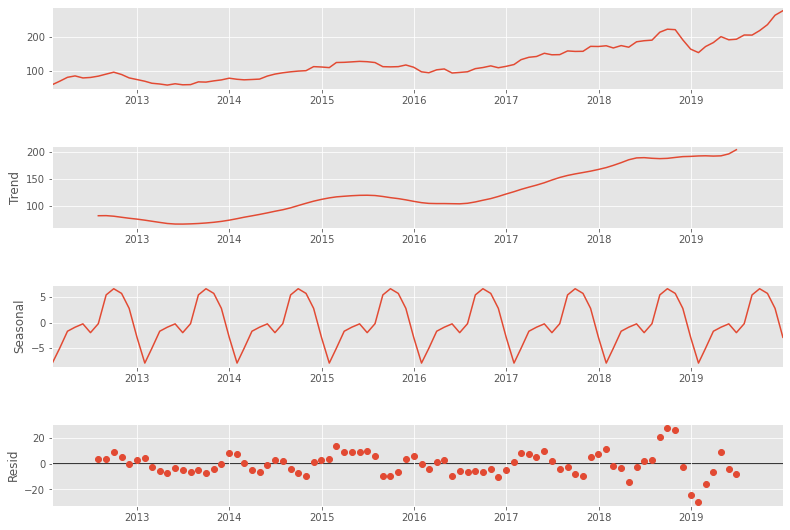

In [35]:
seas_add = seasonal_decompose(df_m, model='additive')
seas_add.plot()
plt.gcf().set_size_inches(12, 8);

<font color='brown'><b>Repeating patterns are seen here. <font color='maroon'><b>Seasonality</font> refers to predictable changes that occur over a one-year period in a business or economy based on the seasons including calendar or commercial seasons.

### <font color='orange'><b>Seasonal Subseries Plot :

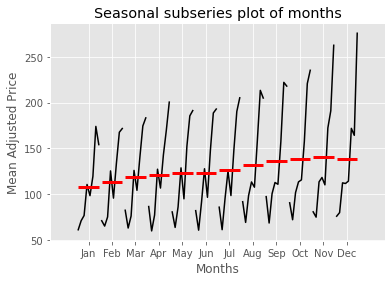

In [36]:
month_plot(df['Close'].resample('M').mean())
plt.title('Seasonal subseries plot of months')
plt.xlabel('Months')
plt.ylabel('Mean Adjusted Price')
plt.show()

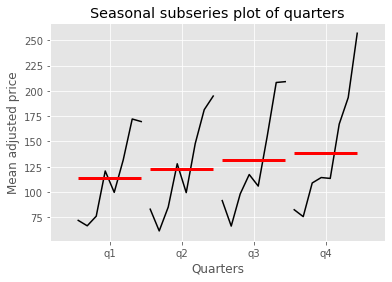

In [37]:
quarter_plot(df['Close'].resample('Q').mean())
plt.title('Seasonal subseries plot of quarters')
plt.xlabel('Quarters')
plt.ylabel('Mean adjusted price')
plt.show()

<font color='maroon'><b><I>The quarter plot shows the seasonality more clearly than the month plot.

## <font color='magenta'><b>Test for Stationarity :

<font color='green'><b>Rolling statistics:-

<font color='peach'><b>This method gave a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plot and then it is observed whether it varies with time or not. In this method, a moving window of time is taken (here since the time series has holidays and totally 2011 records so taking approx. 252 days per year, 8 months is taken as window) and then the mean of that time period is calculated as the current value.

### <font color='orange'><b>Augmented Dickey-Fuller Test :

<font color='green'><b>Ad-fuller test <font color='peach'><b>is one of the unit root test.A unit root test tests whether a time series is not stationary and consists of a unit root in time series analysis. The presence of a unit root in time series defines,</font>

<font color='green'><b>Null Hypothesis - <font color='peach'><b>Time series has unit root, hence not stationary

<font color='green'><b>Alternate Hypothesis - <font color='peach'><b>Time series has no unit root, hence stationary
    
<font color='green'><b><I> If p-value is less than 0.05, reject Null Hypothesis

<font color='green'><b><I>If p-value is greater than 0.05, fail to reject Null Hypothesis
    
<font color='peach'><b>Mathematically a unit root test is represented as yt = Dt + zt + et
    
<font color='peach'><b>where Dt - Deterministic component,  zt - Stochastic component,  et - stationary error process
    
<font color='peach'><b>The unit root test's basic concept is to determine whether the zt (stochastic component ) consists of a unit root or not, which is nothing but element of uncertainity in the time series, whether it recovers from shock and reverts to trend in long run or never recovers from the shock.


### <font color='cyan'><b><I>Function to Test Stationarity :

In [38]:
def test_stationarity(series):
    
    #Determine rolling statistics
    movingAverage = series.rolling(window=8).mean()
    movingSD = series.rolling(window=8).std()
    
    #Plot rolling statistics
    plt.plot(series, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #ad-fuller test
    stat_test = adfuller(series,autolag='AIC')
    print('Results of Dickey Fuller Test:')
    print()
    print('Test Statistic : ',stat_test[0])
    print('p value : ',stat_test[1])
    print('Number of Lags : ',stat_test[2])
    print('Critical values : ')
    for key, val in stat_test[4].items():
        print('\t',key, ': ',val)
    print()    
    if stat_test[1] > 0.05:
        print('Series is non-stationary')
    else:
        print('Series is stationary')

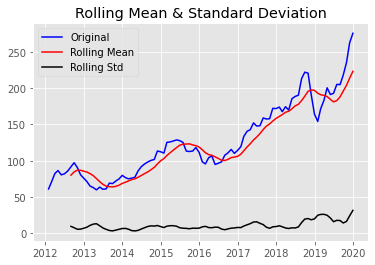

Results of Dickey Fuller Test:

Test Statistic :  0.511965498459759
p value :  0.9852322761789652
Number of Lags :  1
Critical values : 
	 1% :  -3.5019123847798657
	 5% :  -2.892815255482889
	 10% :  -2.583453861475781

Series is non-stationary


In [39]:
test_stationarity(df_m)

<font color='maroon'><b>Observation :

<font color='brown'><b>The graph of rolling mean and standard deviation are not constant.

<font color='brown'><b>The p value is greater than 0.05 and the test statistic is more than the critical values. This suggests that we cannot reject the null hypothesis which means that the process has unit root, and the time series is non-stationary that has the time-dependent structure.
    
<font color='maroon'><b>The series is non-stationary.
    

#### <font color='magenta'><b>Check the order of non-seasonal differencing needed using pmdarima and Differencing the time series :

In [40]:
diff = pm.arima.ndiffs(df_m['Close'],max_d=4)
print(f'Order of non-seasonal Differencing = {diff}')

Order of non-seasonal Differencing = 1


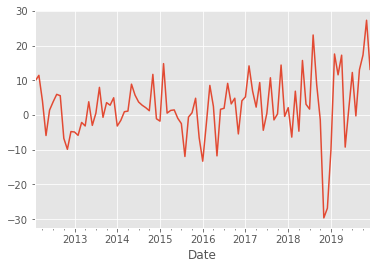

In [41]:
dfm_lag = df_m['Close'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).dropna()
dfm_lag.plot();

In [42]:
diff1 = pm.arima.ndiffs(dfm_lag,max_d=4)
print(f'Order of non-seasonal Differencing = {diff1}')

Order of non-seasonal Differencing = 0


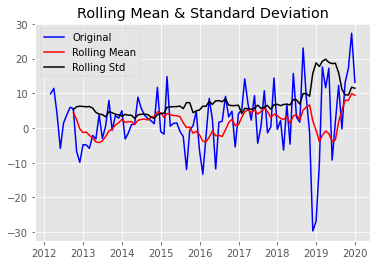

Results of Dickey Fuller Test:

Test Statistic :  -6.549178388231945
p value :  8.940119318440014e-09
Number of Lags :  0
Critical values : 
	 1% :  -3.5019123847798657
	 5% :  -2.892815255482889
	 10% :  -2.583453861475781

Series is stationary


In [43]:
test_stationarity(dfm_lag)

<font color='maroon'><b>Observation :

<font color='brown'><b>The graph of rolling mean and standard deviation are constant.

<font color='brown'><b>The p value is very low and the test statistic is less than 1% critical value. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

<font color='brown'><b>Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

<font color='maroon'><b>The series is trend stationary now.

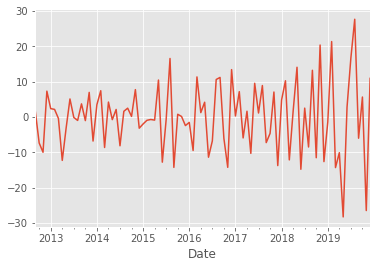

In [44]:
dfm_lag_se = dfm_lag.rolling(window=8).apply(lambda x: x.iloc[1] - x.iloc[0]).dropna()
dfm_lag_se.plot();

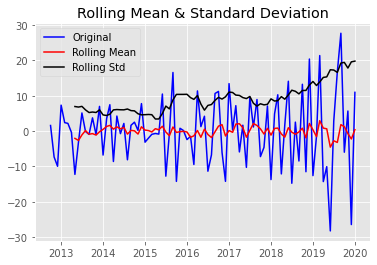

Results of Dickey Fuller Test:

Test Statistic :  -5.98300779222313
p value :  1.8196351010035204e-07
Number of Lags :  7
Critical values : 
	 1% :  -3.5148692050781247
	 5% :  -2.8984085156250003
	 10% :  -2.58643890625

Series is stationary


In [45]:
test_stationarity(dfm_lag_se)

<font color='maroon'><b>Observation :

<font color='brown'><b>The graph of rolling mean and standard deviation are constant.

<font color='brown'><b>The p value is very low and the test statistic is less than 1% critical value. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

<font color='brown'><b>Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
    
<font color='maroon'><b>The series is stationary now.    

## <font color='magenta'><b>ACF and PACF plots :

<font color='purple'><b><I>Autocorrelation function (ACF): At lag k, this is the correlation between series values that are k intervals apart. 
    
<font color='purple'><b><I>Partial autocorrelation function (PACF): At lag k, this is the correlation between series values that are k intervals apart, accounting for the values of the intervals between.

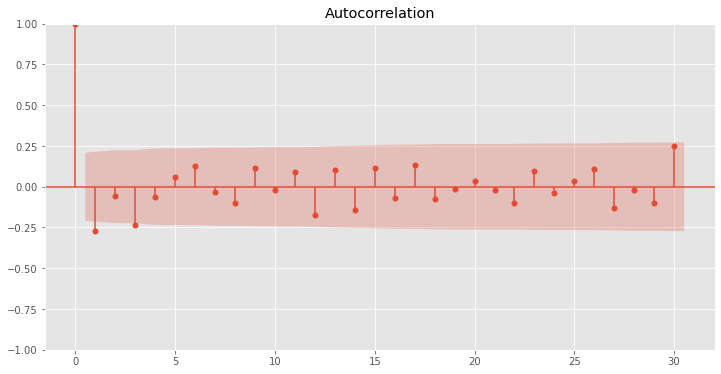

In [46]:
fig, ax = plt.subplots(figsize=(12,6))
acf = plot_acf(dfm_lag_se,lags=30,ax=ax)

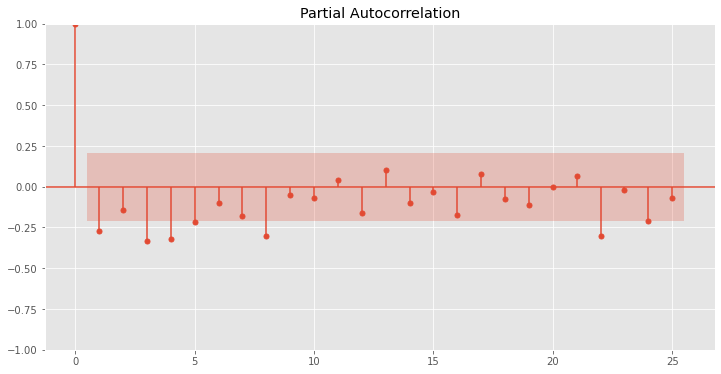

In [47]:
fig, ax = plt.subplots(figsize=(12,6))
pacf = plot_pacf(dfm_lag_se,lags=25,ax=ax)

<font color='maroon'><b>Observation :

<font color='brown'><b>In both ACF and PACF plots, the spike at one is significant so it is first order MA model from ACF, q=1 and first order AR model from PACF,p=1 --> ARMA(1,1). 
    
<font color='brown'><b>Since the time series needed first order differencing to make it stationary, d=1. So ARIMA(1,1,1),where
    
<font color='brown'><b><I>    p - non-seasonal AutoRegressive(AR) order
    
<font color='brown'><b><I>    q - non-seasonal Moving Average(MA) order
    
<font color='brown'><b><I>    d - non-seasonal differencing
    
<font color='brown'><b>For the seasonality, other than initial spikes there is a spike at 8 in PACF plot, so order for AR, P=1. And there are no significant spikes on ACF plot other than initial ones, so MA order, Q=0. Since the time series had seasonality and we did first order seasonal differencing D=1, where
  
<font color='brown'><b><I>    P - seasonal AutoRegressive(AR) order
    
<font color='brown'><b><I>    Q - seasonal Moving Average(MA) order
    
<font color='brown'><b><I>    D - seasonal differencing
    
    
    

### <font color=magenta><b>Split into train and test data :

In [48]:
train = df.iloc[:len(df)-249]

# Taking last one year for testing
test = df.iloc[len(df)-249:]
test.head(),test.tail()

(                 Close
 Date                  
 2019-01-02  157.919998
 2019-01-03  142.190002
 2019-01-04  148.259995
 2019-01-07  147.929993
 2019-01-08  150.750000,
                  Close
 Date                  
 2019-12-23  284.000000
 2019-12-24  284.269989
 2019-12-26  289.910004
 2019-12-27  289.799988
 2019-12-30  291.519989)

### <font color='green'><b>ARIMA model :

In [49]:
model_1 = ARIMA(train,order=(1,1,1))
model_1 = model_1.fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1746
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3621.613
Date:                Sun, 12 Feb 2023   AIC                           7249.226
Time:                        21:54:31   BIC                           7265.619
Sample:                    01-03-2012   HQIC                          7255.287
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7990      0.094     -8.474      0.000      -0.984      -0.614
ma.L1          0.8391      0.087      9.652      0.000       0.669       1.009
sigma2         3.7171      0.063     58.780      0.000       3.593       3.841
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3267.45
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
start = len(train)
end = len(train)+len(test)-1
pred1 = model_1.predict(start=start,end=end,type='levels')

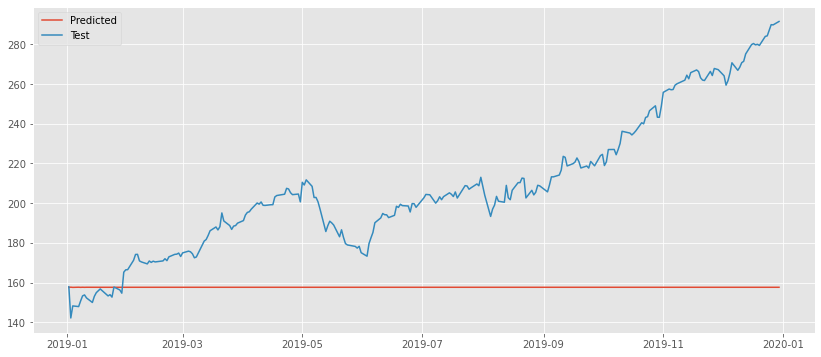

In [51]:
plt.figure(figsize=(14,6))
plt.plot(pred1, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

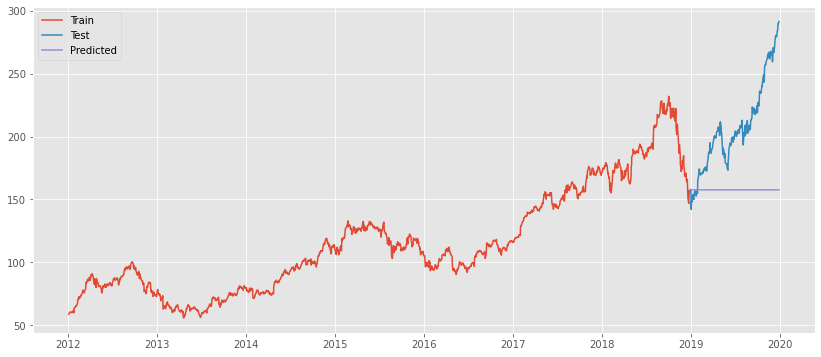

In [52]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred1, label='Predicted')
plt.legend(loc='best')
plt.show()

<font color='maroon'><b><I>Arima model do not capture seasonality.

In [53]:
rmse = sqrt(mean_squared_error(pred1,test))

print('Root Mean Squared Error of ARIMA model =',rmse)

Root Mean Squared Error of ARIMA model = 60.42926803962446


In [54]:
test.mean()

Close    207.585462
dtype: float64

### <font color='green'>SARIMA with Quarterly Seasonality :

In [55]:
model_sr = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,0,66))
model_sr = model_sr.fit()
model_sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1746
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 66)   Log Likelihood               -3804.805
Date:                             Sun, 12 Feb 2023   AIC                           7617.611
Time:                                     21:55:30   BIC                           7639.315
Sample:                                 01-03-2012   HQIC                          7625.651
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2085      0.231     -0.903      0.367      -0.661       0.244
ma.L1          0.2773      0.230      1.205      0.228      -0.174       0.728
ar.S.L66      -0.5284      0.018    -29.576      0.000      -0.563      -0.493
sigma2         5.3735      0.098     54.730      0.000       5.181       5.566
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1962.44
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
pred4 = model_sr.predict(start=start,end=end)

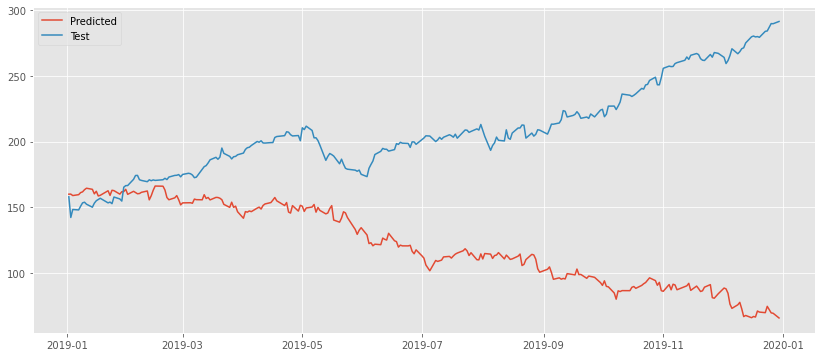

In [57]:
plt.figure(figsize=(14,6))
plt.plot(pred4, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

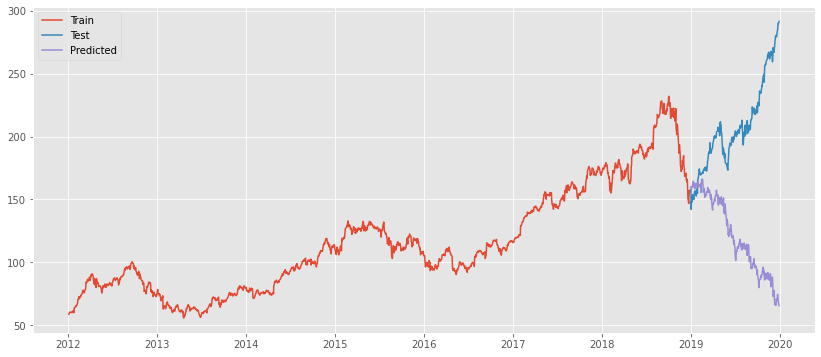

In [58]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred4, label='Predicted')
plt.legend(loc='best')
plt.show()

In [59]:
rmse4 = sqrt(mean_squared_error(pred4,test))

print('Root Mean Squared Error of SARIMA with Quarterly Seasonality =',rmse4)

Root Mean Squared Error of SARIMA with Quarterly Seasonality = 105.74678753175385


### <font color='green'><b>ARIMA with Seasonal order using Maximum likelihood estimation :

In [60]:
model_se = sm.tsa.arima.ARIMA(train,order=(1,1,1),seasonal_order=(1,1,0,251))
result = model_se.fit(method='innovations_mle',low_memory=True,cov_type='none')

In [61]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1746
Model:             ARIMA(1, 1, 1)x(1, 1, [], 251)   Log Likelihood               -3384.443
Date:                            Sun, 12 Feb 2023   AIC                           6776.885
Time:                                    21:57:07   BIC                           6798.122
Sample:                                01-03-2012   HQIC                          6784.798
                                     - 12-31-2018                                         
Covariance Type:                     Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8199        nan        nan        nan         nan         nan
ma.L1          0.8440        nan        nan        nan         nan         nan
ar.S.L251     -0.3962        nan        nan        nan         nan         nan
sigma2         5.2812        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               902.55
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

<font color='maroon'><b>About the Arima with Seasonal order Model :

<font color='maroon'><b><I>- In state space form and then applying the Kalman filter to compute the log-likelihood, the dimension of the state space form of an ARIMA model grows quickly with the number of periods in a complete season, when the seasonality is more granular.

<font color='maroon'><b><I>The Kalman filter requires multiplying matrices with this dimension, and by default, memory is allocated for matrices of this dimension for each of your time periods(that's why it takes forever to run and it takes up a lot of memory too).

<font color='maroon'><b><I>For the solution above, instead of computing the log-likelihood using the Kalman filter, we compute it something called the innovations algorithm. Then we only run the Kalman filter once to compute the results object (this allows for e.g. forecasting). The low_memory=True option instructs the model not to store all of the large-dimensional matrices for each time step, and the cov_type=None option instructs the model not to try to compute standard errors for the model's parameters (which would require a lot more log-likelihood evaluations).

In [82]:
pred2 = result.predict(start=start,end=end,type='levels')

MemoryError: Unable to allocate 484. MiB for an array with shape (504, 504, 250) and data type float64

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(pred2, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred2, label='Predicted')
plt.legend(loc='best')
plt.show()

In [83]:
rmse2 = sqrt(mean_squared_error(pred2,test))

print('Root Mean Squared Error of ARIMA with seasonal order using innovations_mle method =',rmse2)

NameError: name 'pred2' is not defined

<font color='maroon'><b><I>This model has captured seasonality and the rmse is low compared to non-seasonal arima and sarima models.

### <font color='green'><b>Holt-Winters Triple Exponential Smoothing :

In [84]:
model_h = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=252)
model_h = model_h.fit()
model_h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    Close   No. Observations:                 1746
Model:             ExponentialSmoothing   SSE                           5518.211
Optimized:                         True   AIC                           2521.168
Trend:                   Multiplicative   BIC                           3920.229
Seasonal:                Multiplicative   AICC                          2611.043
Seasonal Periods:                   252   Date:                 Sun, 12 Feb 2023
Box-Cox:                          False   Time:                         22:01:30
Box-Cox Coeff.:                    None                                         
==================================================================================
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950038                alpha                 True
smoothing_trend                0.0001001                 beta                 True
smoothing_seasonal             0.0049922                gamma                 True
initial_level                  82.121108                  l.0                 True
initial_trend                  1.0001707                  b.0                 True
initial_seasons.0              0.9664150                  s.0                 True
initial_seasons.1              0.9638898                  s.1                 True
initial_seasons.2              0.9720775                  s.2                 True
initial_seasons.3              0.9848872                  s.3                 True
initial_seasons.4              0.9838434                  s.4                 True
initial_seasons.5              0.9875422                  s.5                 True
initial_seasons.6              0.9848421                  s.6                 True
initial_seasons.7              0.9718623                  s.7                 True
initial_seasons.8              0.9743293                  s.8                 True
initial_seasons.9              0.9940933                  s.9                 True
initial_seasons.10             0.9939054                 s.10                 True
initial_seasons.11             0.9713589                 s.11                 True
initial_seasons.12             0.9749684                 s.12                 True
initial_seasons.13             0.9860276                 s.13                 True
initial_seasons.14             0.9928408                 s.14                 True
initial_seasons.15             1.0009891                 s.15                 True
initial_seasons.16             1.0116931                 s.16                 True
initial_seasons.17             1.0138629                 s.17                 True
initial_seasons.18             1.0164701                 s.18                 True
initial_seasons.19             1.0262195                 s.19                 True
initial_seasons.20             1.0355164                 s.20                 True
initial_seasons.21             1.0435272                 s.21                 True
initial_seasons.22             1.0529001                 s.22                 True
initial_seasons.23             1.0555042                 s.23                 True
initial_seasons.24             1.0510869                 s.24                 True
initial_seasons.25             1.0493314                 s.25                 True
initial_seasons.26             1.0583794                 s.26                 True
initial_seasons.27             1.0614627                 s.27                 True
initial_seasons.28             1.0544399                 s.28                 True
initial_seasons.29             1.0592033                 s.29          

In [85]:
pred3 = model_h.predict(start=start,end=end)

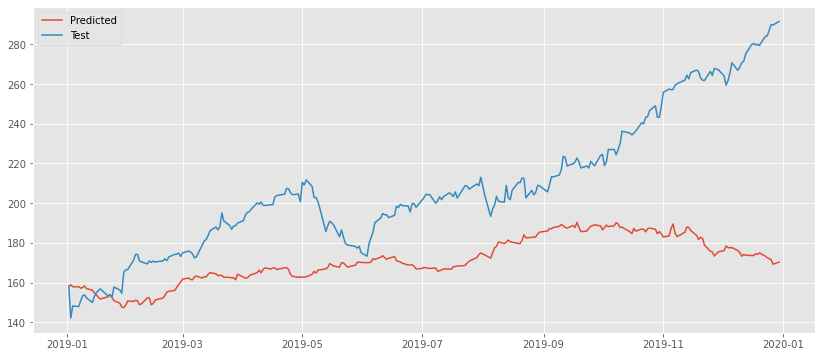

In [71]:
plt.figure(figsize=(14,6))
plt.plot(pred3, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

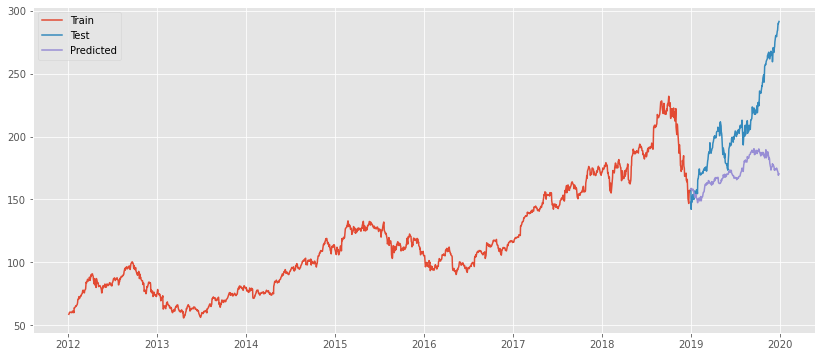

In [72]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred3, label='Predicted')
plt.legend(loc='best')
plt.show()

In [73]:
rmse3 = sqrt(mean_squared_error(pred3,test))

print('Root Mean Squared Error of Holt Winters Triple Exponential Smoothing =',rmse3)

Root Mean Squared Error of Holt Winters Triple Exponential Smoothing = 45.623441092817515


### <font color='purple'><b> Summarizing :

In [75]:
data1 = {'Models':['ARIMA','ARIMA with Seanonal oder','SARIMA with Quaterly Seasonality',
                   'Holt-Winters Triple Exponential Smoothing with Multiplicative Seasonality',
                   ],
       'Root Mean Squared Error':[rmse,rmse2,rmse4,rmse3]}
Model = pd.DataFrame(data1)
Model = Model.sort_values('Root Mean Squared Error').reset_index(drop=True)
Model

NameError: name 'rmse2' is not defined

In [76]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=Model,x='Root Mean Squared Error',y='Models',palette='flare',ci=None)
plt.yticks(fontsize=20,fontweight='bold');
for i in ax.containers:
    ax.bar_label(i,fontsize=18)

NameError: name 'Model' is not defined

<Figure size 720x432 with 0 Axes>

<font color='purple'><b><I>As the exponential smoothing methods predict future patterns to heavily represent current ones they are less effective in long term forecasting. So selecting Arima with Seasonal order and Sarima with Quaterly seasonality as the best models for forecasting.
    
<font color='purple'><b><I>As Sarima with Quaterly Seasonality looks computationally heavy, using Arima with seasonal order for the forecasting.

### <font color='magenta'><b>Training the best model on the whole dataset to forecast  :

### <font color='hotpink'><b>Arima with Seasonal order :

In [77]:
model_se1 = sm.tsa.arima.ARIMA(df,order=(1,1,1),seasonal_order=(1,1,0,251))
model_se1 = model_se1.fit(method='innovations_mle',low_memory=True,cov_type='none')
model_se1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1995
Model:             ARIMA(1, 1, 1)x(1, 1, [], 251)   Log Likelihood               -4153.280
Date:                            Sun, 12 Feb 2023   AIC                           8314.560
Time:                                    22:01:15   BIC                           8336.413
Sample:                                01-03-2012   HQIC                          8322.640
                                     - 12-30-2019                                         
Covariance Type:                     Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8387        nan        nan        nan         nan         nan
ma.L1          0.8604        nan        nan        nan         nan         nan
ar.S.L251     -0.5440        nan        nan        nan         nan         nan
sigma2         6.5356        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1510.47
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.91   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

### <font color='hotpink'><b>Forecast for next 60 days :

In [78]:
f = pd.DataFrame(model_se1.forecast(60))
f

predicted_mean
2019-12-31      289.376359
2020-01-02      289.883961
2020-01-03      290.392608
2020-01-06      282.074554
2020-01-07      286.607164
2020-01-08      286.342768
2020-01-09      288.145744
2020-01-10      290.316141
2020-01-13      290.243555
2020-01-14      289.495828
2020-01-15      288.470314
2020-01-16      290.374845
2020-01-17      292.240680
2020-01-21      292.146721
2020-01-22      294.187554
2020-01-23      292.652664
2020-01-24      292.514278
2020-01-27      291.151899
2020-01-28      293.490928
2020-01-29      291.282787
2020-01-30      288.859193
2020-01-31      293.890879
2020-02-03      292.507233
2020-02-04      292.001041
2020-02-05      294.411607
2020-02-06      295.935198
2020-02-07      292.004677
2020-02-10      288.316405
2020-02-11      291.634181
2020-02-12      289.287305
2020-02-13      287.566114
2020-02-14      287.926789
2020-02-18      291.637553
2020-02-19      292.350275
2020-02-20      294.231743
2020-02-21      297.790128
2020-02-24      297.043578
2020-02-25      297.598679
2020-02-26      297.749213
2020-02-27      298.572485
2020-02-28      300.450925
2020-03-02      301.554107
2020-03-03      302.068657
2020-03-04      302.322936
2020-03-05      300.479841
2020-03-06      300.677439
2020-03-09      300.088226
2020-03-10      300.193524
2020-03-11      302.032858
2020-03-12      303.988422
2020-03-13      306.007013
2020-03-16      307.874661
2020-03-17      308.012530
2020-03-18      308.046597
2020-03-19      307.481407
2020-03-20      307.881962
2020-03-23      309.562380
2020-03-24      307.687490
2020-03-25      304.474461
2020-03-26      302.268769

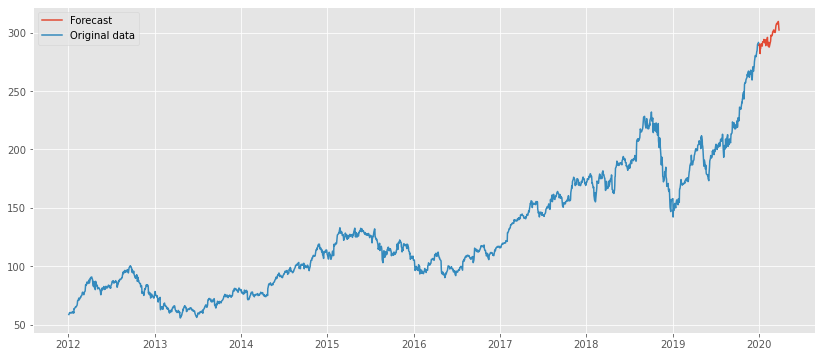

In [79]:
plt.figure(figsize=(14,6))
plt.plot(f, label='Forecast')
plt.plot(df, label='Original data')
plt.legend(loc='best')
plt.show()

### <font color='magenta'><b>Saving the best model :

### <font color='hotpink'><b>Arima with Seasonal order :

In [80]:
filename = 'model_trained.pkl'

In [81]:
pickle.dump(model_se1,open(filename,'wb'))